In [1]:
import os, glob, cv2, math, csv, tqdm, random, data_list_loader, keras
from PIL import Image
import numpy as np
from keras import backend as k
from keras import applications, optimizers, losses, layers
from keras import layers ,losses
from keras.layers import Dropout, Input, concatenate, Dense, LeakyReLU, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Flatten
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers.convolutional import Conv2D, Deconv2D, Conv2DTranspose
from keras.utils import generic_utils
from keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def img_list_train_split(mpi, fly):
    mpi_img, mpi_lab = data_list_loader.MPI_dataset_list_loader(mpi)
#     kitti_img, kitti_lab = data_list_loader.kitti_dataset_list_loader(kitti)
    fly_img, fly_lab = data_list_loader.flying_dataset_list_loader(fly)

    total_img = mpi_img  + fly_img
    total_lab = mpi_lab  + fly_lab
    
    idx = list(range(0,len(total_img)))
    random.shuffle(idx)
    
    total_img_c = []
    total_lab_c = []
    
    for i in range(len(idx)):
        total_img_c.append(total_img[idx[i]])
        total_lab_c.append(total_lab[idx[i]])

    train_img = total_img_c[:-1000]
    train_lab = total_lab_c[:-1000]
    val_img = total_img_c[-1000:]
    val_lab = total_lab_c[-1000:]
    print('% Train images :',len(train_img),'    ''% Validation images :',len(val_img))
    
    return train_img, train_lab, val_img, val_lab

In [3]:
def data_generator(total_img, total_lab, batch):
    total = []        
    while 1:
        idx = list(range(0,len(total_img)))
        idx_batch = random.sample(idx,batch)
        
        bat_img = []
        bat_lab = []
        
        for i in idx_batch:
            img = cv2.resize(np.concatenate((Image.open(total_img[i][0]),Image.open(total_img[i][1])),axis = 2),(512,384))/255.
            lab = cv2.resize(np.array(Image.open(total_lab[i][0])),(512,384))/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), [np.array([cv2.resize(i, (32, 24)) for i in bat_lab]),
                                  np.array([cv2.resize(i, (64, 48)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (128, 96)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (256, 192)) for i in bat_lab])]

In [4]:
def generator(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2))(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2))(conv1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2))(conv2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1))(conv3)
    conv3_1 = LeakyReLU(alpha=0.1)(conv3_1)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv3_1)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1))(conv4)
    conv4_1 = LeakyReLU(alpha=0.1)(conv4_1)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv4_1)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1))(conv5)
    conv5_1 = LeakyReLU(alpha=0.1)(conv5_1)
    conv6 = Conv2D(1024, 3, padding = 'same', strides=(2, 2))(conv5_1)
    conv6 = LeakyReLU(alpha=0.1)(conv6)

    deconv5 = Conv2DTranspose(512, 5,  padding = 'same', use_bias=False, strides=(2, 2))(conv6)
    deconv5 = LeakyReLU(alpha=0.1)(deconv5)
    merge5 = concatenate([deconv5,conv5_1], axis = 3)
    aux1 = Conv2D(3, 5,  padding = 'same' , name = 'aux1')(UpSampling2D(size = (2,2))(merge5))
    aux1_1 = LeakyReLU(alpha=0.1)(aux1)
    
    deconv4 = Conv2DTranspose(256, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge5)
    deconv4 = LeakyReLU(alpha=0.1)(deconv4)
    merge4 = concatenate([deconv4,conv4_1,aux1_1], axis = 3)
    aux2 = Conv2D(3, 5,  padding = 'same' , name = 'aux2')(UpSampling2D(size = (2,2))(merge4))
    aux2_1 = LeakyReLU(alpha=0.1)(aux2)
    
    deconv3 = Conv2DTranspose(128, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge4)
    deconv3 = LeakyReLU(alpha=0.1)(deconv3)
    merge3 = concatenate([deconv3,conv3_1,aux2_1], axis = 3)
    aux3 = Conv2D(3, 5, padding = 'same' , name = 'aux3')(UpSampling2D(size = (2,2))(merge3))
    aux3_1 = LeakyReLU(alpha=0.1)(aux3)
    
    deconv2 = Conv2DTranspose(64, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge3)
    deconv2 = LeakyReLU(alpha=0.1)(deconv2)
    merge2 = concatenate([deconv2,conv2,aux3_1], axis = 3)
    aux4 = Conv2D(3, 5, padding = 'same' , name = 'aux4')(UpSampling2D(size = (2,2))(merge2))
    aux4_1 = LeakyReLU(alpha=0.1)(aux4)
    output = Conv2D(3, 5, activation = 'sigmoid', padding = 'same')(aux4_1)
   
    model = Model(inputs = inputs, outputs = [aux1_1,aux2_1,aux3_1,output])
    return model

In [5]:
batch = 16

mpi = '/data1/flow/MPI'
fly = '/data1/flow/FlyingChairs_release'
#kitti = '/data1/flow/Kitti'

train_img, train_lab, val_img, val_lab = img_list_train_split(mpi, fly)

% Train images : 22913     % Validation images : 1000


In [6]:
gen_input = Input(shape=(384,512,6))
model_gen = generator(gen_input)
model_gen.compile(optimizer = Adam(lr = 0.0001), loss = ['mse','mse','mse','mse'],
                  loss_weights=[0.005,0.02,0.08,0.32])

In [7]:
model_gen.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 512, 6)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 64) 18880       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 192, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 128, 128) 204928      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [8]:
train = data_generator(train_img, train_lab, batch)
val = data_generator(val_img, val_lab, batch)

In [9]:
mc = keras.callbacks.ModelCheckpoint('20190517_flownet_{epoch+5:08d}.h5', period=1)

In [10]:
hist = model_gen.fit_generator(train,steps_per_epoch=5000,epochs=5,validation_data=val, validation_steps=30, callbacks=[mc])

Epoch 1/5


KeyboardInterrupt: 

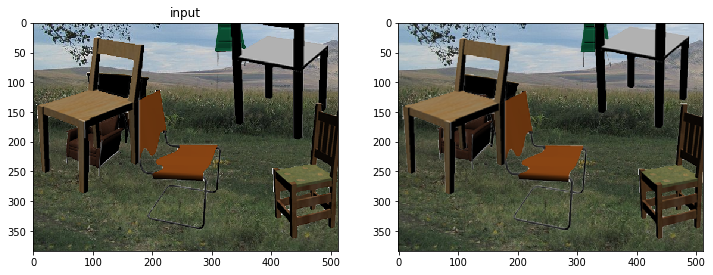

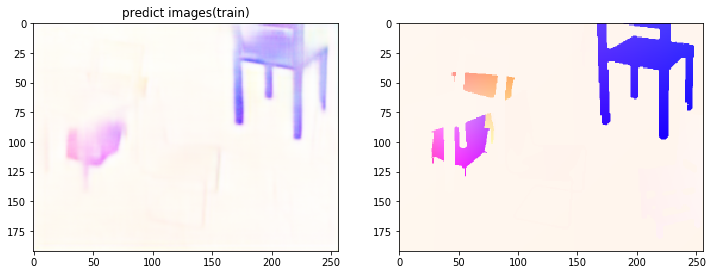

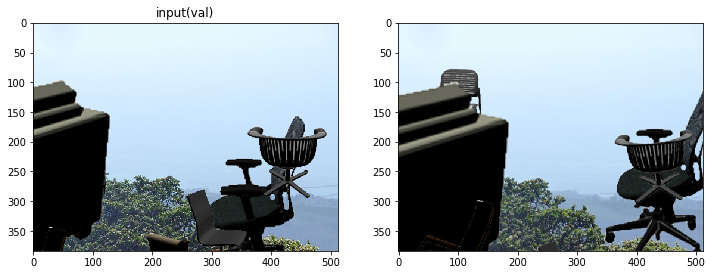

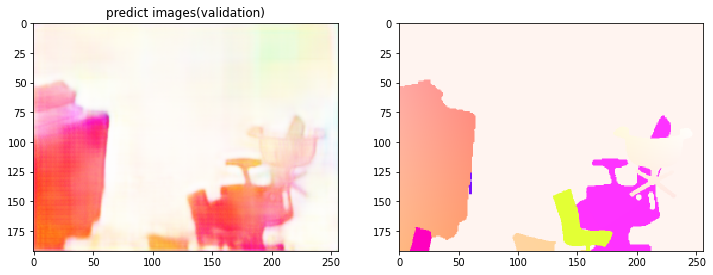

In [19]:
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(train)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()

test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input(val)")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(validation)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()

In [16]:
model_gen.save('flow_net_good_e5.h5')

In [13]:
hist.history.keys()

dict_keys(['val_leaky_re_lu_11_loss', 'val_loss', 'val_leaky_re_lu_13_loss', 'loss', 'val_leaky_re_lu_15_loss', 'conv2d_10_loss', 'leaky_re_lu_13_loss', 'leaky_re_lu_15_loss', 'leaky_re_lu_11_loss', 'val_conv2d_10_loss'])

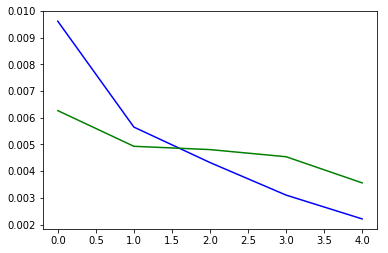

In [14]:
plt.plot(hist.history['loss'],'b-')
plt.plot(hist.history['val_loss'],'g-')
plt.show()

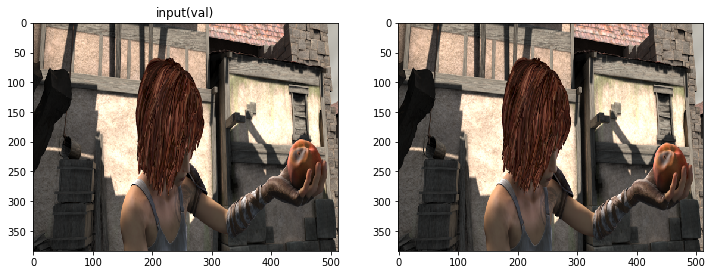

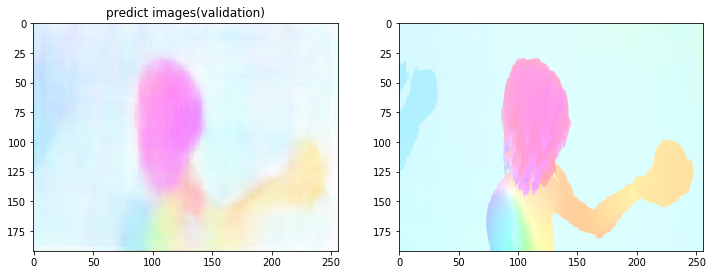

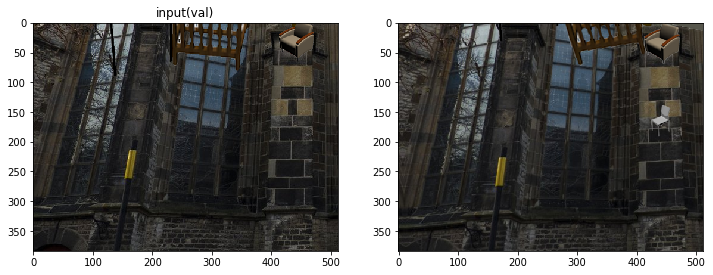

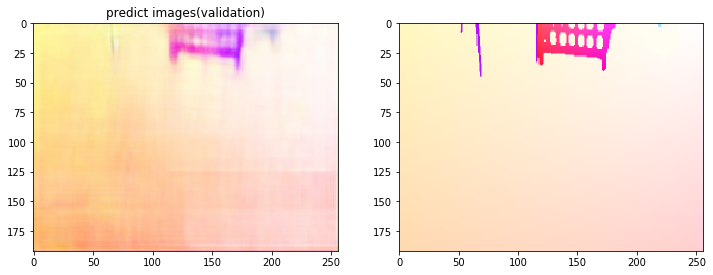

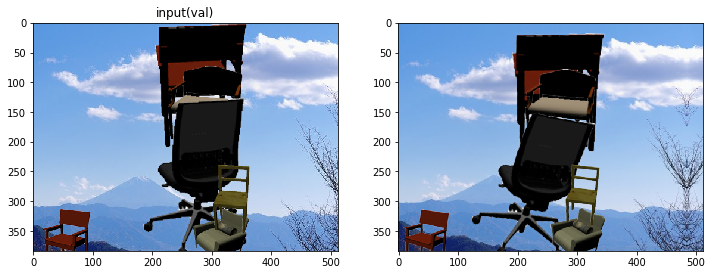

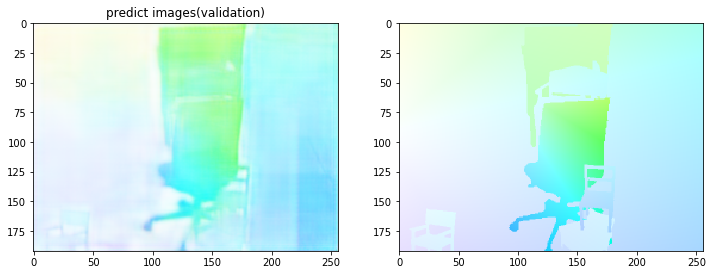

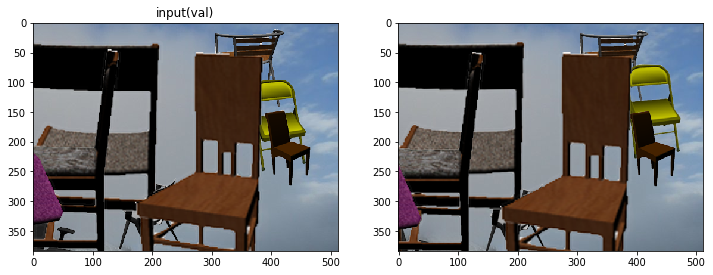

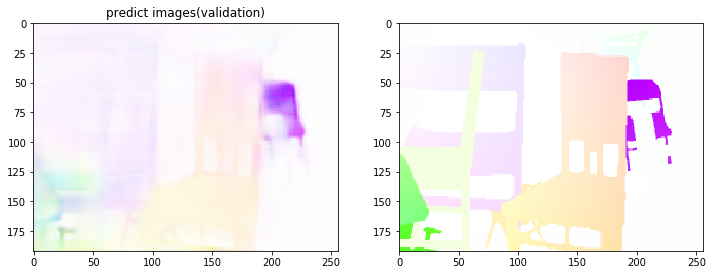

In [15]:
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input(val)")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(validation)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input(val)")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(validation)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input(val)")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(validation)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_img[0][:,:,:3])
plt.title("input(val)")
plt.subplot(122)
plt.imshow(test_img[0][:,:,3:])
plt.show()

test_p = model_gen.predict(test_img)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(test_p[3][0])
plt.title("predict images(validation)")
plt.subplot(122)
plt.imshow(test_lab[3][0])
plt.show()

In [ ]:
kitti_img, kitti_lab = data_list_loader.kitti_dataset_list_loader(kitti)